.. index:: Grid construction

# Examples of grid construction
In addition to the already discussed construction of Cartesian grid using
`dune.grid.structuredGrid` and `dune.grid.cartesianDomain` and
the usage of dictionaries discussed in the [general concepts section](dune-corepy_nb.ipynb),
it is also possible to read grid files using either the `DGF` or `gmsh` format (or other
formats available through the `meshio` package).


In [1]:
import numpy
from matplotlib import pyplot
from dune.alugrid import aluSimplexGrid as leafGridView
from dune.grid import OutputType, reader
from dune.fem.space import lagrange as solutionSpace
from dune.fem.scheme import galerkin as solutionScheme
from ufl import TestFunction, TrialFunction, SpatialCoordinate
from ufl import dx, grad, grad, dot, inner, conditional, sin

.. index:: Grid construction; DGF

## Example using the Dune Grid Format (DGF)

Please read the [Dune Grid Format (DGF)](https://dune-project.org/doxygen/master/group__DuneGridFormatParser.html#details) for a detailed description of DGF.
The format works for 2d or 3d and most DUNE grids can be constructed using a DGF file.
The format allows easy description of boundary ids (see below) and parameters.
See the section about [boundary conditions](boundary_nb.ipynb) to learn how to
use these in a weak form.

.. note:: The DGF is ASCII based and thus only meant for prototyping and
testing. For serious computations use `meshio` or the [pickling approach](backuprestore_nb.ipynb).

We start with a simple [grid of triangles](triangle.dgf)

In [2]:
domain2d = (reader.dgf, "triangle.dgf")

# specify dimgrid since it cannot be easily extracted from the dgf file
aluView = leafGridView(domain2d, dimgrid=2)
aluView.plot(figsize=(5,5))


.. index:: Grid construction; gmsh (from file)

There is also a `reader.gmsh` option allowing previously stored `gmsh` files to be
read. The [grid file](wave_tank.msh) is the one used in the [wave equation](wave_nb.ipynb) example.

In [3]:
waveDomain = (reader.gmsh, "wave_tank.msh")
waveGrid = leafGridView(waveDomain, dimgrid=2)
waveGrid.plot(figure=pyplot.figure(figsize=(10,10)))

<Figure size 500x500 with 0 Axes>


.. index:: Grid construction; pygmsh

## 3D example (using PyGmsh)
In this example we use **pygmsh** to construct a tetrahedral mesh and solve a
simple Laplace problem.
The following code is taken from the **pygmsh** homepage.

In [4]:
try:
    import pygmsh
    with pygmsh.geo.Geometry() as geom:
        poly = geom.add_polygon([
              [ 0.0,  0.5, 0.0], [-0.1,  0.1, 0.0], [-0.5,  0.0, 0.0],
              [-0.1, -0.1, 0.0], [ 0.0, -0.5, 0.0], [ 0.1, -0.1, 0.0],
              [ 0.5,  0.0, 0.0], [ 0.1,  0.1, 0.0] ], mesh_size=0.05)
        geom.twist(
            poly,
            translation_axis=[0, 0, 1], rotation_axis=[0, 0, 1], point_on_axis=[0, 0, 0],
            angle=numpy.pi / 3,
        )
        mesh = geom.generate_mesh(verbose=False)

    points, cells = mesh.points, mesh.cells_dict
    domain3d = {"vertices":points.astype("float"), "simplices":cells["tetra"]}
except ImportError: # pygmsh not installed - use a simple cartesian domain
    print("pygmsh module not found using a simple Cartesian domain - ignored")
    from dune.grid import cartesianDomain
    domain3d = cartesianDomain([-0.25,-0.25,0],[0.25,0.25,1],[30,30,60])

gridView3d  = leafGridView(domain3d)
space3d = solutionSpace(gridView3d, order=1)

u = TrialFunction(space3d)
v = TestFunction(space3d)
x = SpatialCoordinate(space3d)
scheme3d = solutionScheme((inner(grad(u),grad(v))+inner(u,v))*dx ==
                        conditional(dot(x,x)<.01,100,0)*v*dx,
                        solver='cg')

uh3d = space3d.interpolate([0],name="solution")
scheme3d.solve(target=uh3d)
# note: plotting with matplotlib not yet available for 3d grids
gridView3d.writeVTK('3dexample', pointdata=[uh3d],
                    outputType=OutputType.appendedraw)

![3d laplace problem](figures/3dexample.png)


.. index:: Grid construction; gmsh2dgf (from Python)

## Converting gmsh to DGF

Using the above convenient way of generating grids
in Python we can then store those as DGF which allows to
add boundary ids of vertex and element parameters
in a simple way. Use `gmsh2DGF` from
[gmsh2dgf](gmsh2dgf_nb.ipynb) to convert the above `points` and `cells`
to a string which can be read by `reader.dgfString`.


In [5]:
from gmsh2dgf import gmsh2DGF
from dune.grid import reader

dgf = gmsh2DGF(points, cells)
domain3d = (reader.dgfString, dgf)
gridView3d  = leafGridView(domain3d, dimgrid=3)


.. tip:: Store the DGF mesh to a file for later reuse with `reader.dgf`, see
above.

In [6]:
with open ("3dmesh.dgf", "w") as file:
    file.write(dgf)


.. index:: Grid construction; Boundary Ids


### Attaching boundary ids to a grid constructed with gmsh using DGF

The [Dune Grid Format (DGF)](https://dune-project.org/doxygen/master/group__DuneGridFormatParser.html#details) allows
to either specify `BoundarySegments` or a `BoundaryDomain`. Boundary segments require to specify a boundary id
for a selection of intersections of an element with the boundary,
e.g. a collection of edges of triangles located on the boundary. For testing
and prototyping it is very convenient to use the boundary domain approach
instead, where for each boundary id (short: `bnd id`) a bounding box is described and each
boundary segment that is found inside this box is assigned the `bnd id`. This
approach also allows to specify a default value which is assigned to all
segments not found in any of the specified boxes. This approach works in 2d as
well as 3d.

.. tip:: Specify the bounding box for simple boundaries such as outer walls
and straight lines and surfaces and use the default value to mark
a particularly complex boundary in the interior.

In [7]:
try:
    with pygmsh.occ.Geometry() as geom:

        # Define domain
        L = 1; H = 1
        # circles
        c = 0.2; r = 0.05

        # Grid size function
        def size(dim, tag, x, y, z, lc):
            resolution = 0.06
            d = ((x - c)**2 + (y - c)**2)**0.5
            if d < 3 * r:
                return 0.25*resolution

            d = ((x - (1-c))**2 + (y - (1-c))**2)**0.5
            if d < 3 * r:
                return 0.25*resolution

            # default is a coarser mesh
            return resolution

        # create rectangle and circles
        rectangle = geom.add_rectangle([0, 0, 0], L, H)
        obs1 = geom.add_ball([c, c, 0], r)
        obs2 = geom.add_ball([1-c, 1-c, 0], r)
        # subtract the two obstacles from the volume to create holes
        geom.boolean_difference(rectangle, [obs1, obs2])
        geom.set_mesh_size_callback(size)
        mesh = geom.generate_mesh(dim=2)

        eps = 0.01 # tolerance
        # lower left circle min and max
        c1 = [c - r - eps, c + r + eps]
        # upper right circle min and max
        c2 = [(1-c) - r - eps, (1-c) + r + eps]

        # dictionary containing id and a list containing the lower left and upper right corner of the bounding box
        bndDomain = {1: [[-1.0 , -1.0 ], [0.0  , H+0.1]], # bounding box inflow
                     2: [[   L , -1.0 ], [L+1.0, H+0.1]], # bounding box outflow
                     4: [[c1[0], c1[0]], [c1[1], c1[1]]], # bounding box lower left circle
                     5: [[c2[0], c2[0]], [c2[1], c2[1]]], # bounding box upper right circle
                     3: "default"  # top and bottom wall,
                     # which are all other segments not contained in the above bounding boxes
                    }

        # return dgf string which can be read by DGF parser or written to file for later use
        dgf = gmsh2DGF(mesh.points, mesh.cells_dict, bndDomain=bndDomain, dim=2)
        domain2d = (reader.dgfString, dgf)
except ImportError: # pygmsh not installed - use a simple cartesian domain
    print("pygmsh module not found using a simple Cartesian domain - ignored")
    from dune.grid import cartesianDomain
    domain2d = cartesianDomain([-0.25,-0.25],[0.25,0.25],[30,30])

gridView2d = leafGridView(domain2d, dimgrid=2)


.. index:: Grid construction; Visualize boundary Ids

### Visualizing Boundary Ids

After construction of a grid we can visualize boundary ids
by assigning a piecewise constant function to hold the value of adjacent
boundaries. This is not necessarily unique but works in most cases.


In [8]:
from gmsh2dgf import projectBoundaryIds

bndIds = projectBoundaryIds( gridView2d )
bndIds.plot()


.. index:: Grid construction; meshio

## Using `meshio` to read a gmsh file

We will use the `meshio` package to read a gmsh file, extract the points
and cells and use that to construct a Dune grid. The final part is then
quite similar to the above. We use the [2D grid](wave_tank.msh) from the
[wave equation](wave_nb.ipynb) test case. Note that this is a 2D grid but the points are
returned as 3D points so we need to remove the final columns containing
only zeros. We have already seen this grid above so let's zoom in to the
'slit' region...

.. todo:: Add a way to describe boundary data when using `meshio`.


In [9]:
try:
    import numpy as np
    import meshio
    mesh = meshio.read("wave_tank.msh")
    points = np.delete( mesh.points, 2, 1) # remove the z component from the points
    cells = mesh.cells_dict
    waveDomain = {"vertices":points.astype("float"), "simplices":cells["triangle"]}
    waveGrid = leafGridView(waveDomain)
    waveGrid.plot(figure=pyplot.figure(figsize=(10,10)),xlim=[0.3,1.7],ylim=[-0.2,1.2])
except ImportError:
    print("This example requires the meshio package which can be installed using pip.")

<Figure size 500x500 with 0 Axes>


.. index:: Grid construction; meshio (quadrilateral grids)

Here is a second example where we want to read a [gmsh file](quads.msh) containing
quadrilateral elements. Note that the vertices of the cells are ordered
counterclockwise which is not identical to the ordering required by the
[Dune reference element](https://www.dune-project.org/doxygen/2.5.0/group__GeometryReferenceElements.html).
The last two vertices need to be exchanged:

In [10]:
if meshio:
    from dune.alugrid import aluCubeGrid
    mesh = meshio.read("quads.msh")
    points2d = np.delete(mesh.points,2,1)
    cells = mesh.cells_dict['quad']
    cells[:, [2, 3]] = cells[:, [3, 2]]
    domain = {"vertices":points2d, "cubes":cells}
    quadGrid  = aluCubeGrid(domain)
    quadGrid.plot()


## 1D example
It's also possible to create grids in 1D

In [11]:
from dune.grid import onedGrid
v = [numpy.log(i) for i in range(1,100)]
e = [(i,i+1) for i in range(1,len(v))]
g = onedGrid(constructor={"vertices":v, "simplices":e})
s = solutionSpace(g)
x = SpatialCoordinate(s)
u = s.interpolate(sin(x[0]), name="u")
u.plot()

pyplot can very easily be used in 1d using the ``tessellate`` method on
the grid which will be described in more detail in the section about the
bindings for the full [dune grid interface](dune-corepy_nb.ipynb).

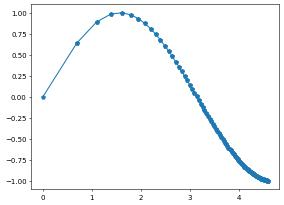

In [12]:
pyplot.plot(g.tessellate()[0], u.pointData(), '-p')